In [1]:
from concrete_autoencoder import ConcreteAutoencoderFeatureSelector

In [2]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

import seaborn as sns

In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'
print("Device")
print(device)

Device
cuda:0


In [5]:
D = 30
N = 10000
z_size = 8

In [6]:
train_data, test_data = generate_synthetic_data_with_noise(N, z_size, D)

In [7]:
class CEConcreteAutoencoderFeatureSelector(ConcreteAutoencoderFeatureSelector):
    def __init__(self, K, output_function, num_epochs = 300, batch_size = None, learning_rate = 0.001, start_temp = 10.0, min_temp = 0.1, tryout_limit = 5):
            super(CEConcreteAutoencoderFeatureSelector, self).__init__(K, output_function, num_epochs, batch_size, learning_rate, start_temp, min_temp, tryout_limit)
    
    
    def fit(self, X, Y = None, val_X = None, val_Y = None):
        if Y is None:
            Y = X
        assert len(X) == len(Y)
        validation_data = None
        if val_X is not None and val_Y is not None:
            assert len(val_X) == len(val_Y)
            validation_data = (val_X, val_Y)
        
        if self.batch_size is None:
            self.batch_size = max(len(X) // 256, 16)
        
        num_epochs = self.num_epochs
        steps_per_epoch = (len(X) + self.batch_size - 1) // self.batch_size
        
        for i in range(self.tryout_limit):
            
            K.set_learning_phase(1)
            
            inputs = Input(shape = X.shape[1:])

            alpha = math.exp(math.log(self.min_temp / self.start_temp) / (num_epochs * steps_per_epoch))
            
            self.concrete_select = ConcreteSelect(self.K, self.start_temp, self.min_temp, alpha, name = 'concrete_select')

            selected_features = self.concrete_select(inputs)

            outputs = self.output_function(selected_features)

            self.model = Model(inputs, outputs)

            self.model.compile(Adam(self.learning_rate), loss = 'binary_crossentropy')
            
            print(self.model.summary())
            
            stopper_callback = StopperCallback()
            
            hist = self.model.fit(X, Y, self.batch_size, num_epochs, verbose = 1, callbacks = [stopper_callback], validation_data = validation_data)#, validation_freq = 10)
            
            if K.get_value(K.mean(K.max(K.softmax(self.concrete_select.logits, axis = -1)))) >= stopper_callback.mean_max_target:
                break
            
            num_epochs *= 2
        
        self.probabilities = K.get_value(K.softmax(self.model.get_layer('concrete_select').logits))
        self.indices = K.get_value(K.argmax(self.model.get_layer('concrete_select').logits))
            
        return self

convert torch tensors to tf tensors

In [8]:
def tf_to_to(df):
    df = df.cpu().numpy()
    return tf.convert_to_tensor(df)

In [9]:
#train_data = tf_to_to(train_data)
#test_data = tf_to_to(test_data)

In [10]:
def decoder(x):
    x = Dense(D)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(2*D)(x)
    x = tf.keras.activations.sigmoid(x)
    return x

#selector = CEConcreteAutoencoderFeatureSelector(K = 3*z_size, output_function = decoder, num_epochs = 800)

#selector.fit(train_data, train_data, test_data, test_data)

In [11]:
#ind = selector.get_support(indices=True)

In [12]:
#sum(ind < 30)

In [13]:
#sum(ind >= 30)

In [14]:
#K.argmax(selector.model.get_layer('concrete_select').logits)

In [15]:
#selector.model.get_layer('concrete_select').logits.shape

End of their implementation and try mine

In [16]:
# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 600
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999
k = 24

In [17]:
global_t = 4

In [18]:
vae_gumbel_truncated = ConcreteVAE_NMSL(2*D, hidden_layer_size = 100, z_size = 20, k = k, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))



In [19]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)

Train Epoch: 1 [0/8000 (0%)]	Loss: 41.706554
Train Epoch: 1 [1280/8000 (16%)]	Loss: 41.148266
Train Epoch: 1 [2560/8000 (32%)]	Loss: 40.526817
Train Epoch: 1 [3840/8000 (48%)]	Loss: 40.001202
Train Epoch: 1 [5120/8000 (64%)]	Loss: 39.352222
Train Epoch: 1 [6400/8000 (80%)]	Loss: 38.744633
Train Epoch: 1 [7680/8000 (96%)]	Loss: 38.255493
====> Epoch: 1 Average loss: 39.9258
Train Epoch: 2 [0/8000 (0%)]	Loss: 38.057285
Train Epoch: 2 [1280/8000 (16%)]	Loss: 37.283543
Train Epoch: 2 [2560/8000 (32%)]	Loss: 36.508724
Train Epoch: 2 [3840/8000 (48%)]	Loss: 35.962147
Train Epoch: 2 [5120/8000 (64%)]	Loss: 35.232903
Train Epoch: 2 [6400/8000 (80%)]	Loss: 35.033081
Train Epoch: 2 [7680/8000 (96%)]	Loss: 34.244965
====> Epoch: 2 Average loss: 35.8920
Train Epoch: 3 [0/8000 (0%)]	Loss: 34.191845
Train Epoch: 3 [1280/8000 (16%)]	Loss: 34.067211
Train Epoch: 3 [2560/8000 (32%)]	Loss: 33.801277
Train Epoch: 3 [3840/8000 (48%)]	Loss: 33.654434
Train Epoch: 3 [5120/8000 (64%)]	Loss: 33.361877
Train E

Train Epoch: 22 [7680/8000 (96%)]	Loss: 32.025845
====> Epoch: 22 Average loss: 32.3327
Train Epoch: 23 [0/8000 (0%)]	Loss: 32.504326
Train Epoch: 23 [1280/8000 (16%)]	Loss: 32.094376
Train Epoch: 23 [2560/8000 (32%)]	Loss: 32.222618
Train Epoch: 23 [3840/8000 (48%)]	Loss: 32.423927
Train Epoch: 23 [5120/8000 (64%)]	Loss: 32.192356
Train Epoch: 23 [6400/8000 (80%)]	Loss: 31.784210
Train Epoch: 23 [7680/8000 (96%)]	Loss: 32.319115
====> Epoch: 23 Average loss: 32.3074
Train Epoch: 24 [0/8000 (0%)]	Loss: 32.102673
Train Epoch: 24 [1280/8000 (16%)]	Loss: 32.210709
Train Epoch: 24 [2560/8000 (32%)]	Loss: 32.499386
Train Epoch: 24 [3840/8000 (48%)]	Loss: 32.140778
Train Epoch: 24 [5120/8000 (64%)]	Loss: 32.476452
Train Epoch: 24 [6400/8000 (80%)]	Loss: 32.458084
Train Epoch: 24 [7680/8000 (96%)]	Loss: 31.992771
====> Epoch: 24 Average loss: 32.2960
Train Epoch: 25 [0/8000 (0%)]	Loss: 32.273911
Train Epoch: 25 [1280/8000 (16%)]	Loss: 32.211315
Train Epoch: 25 [2560/8000 (32%)]	Loss: 31.98535

Train Epoch: 44 [2560/8000 (32%)]	Loss: 32.406708
Train Epoch: 44 [3840/8000 (48%)]	Loss: 32.607452
Train Epoch: 44 [5120/8000 (64%)]	Loss: 31.611601
Train Epoch: 44 [6400/8000 (80%)]	Loss: 32.242756
Train Epoch: 44 [7680/8000 (96%)]	Loss: 32.511906
====> Epoch: 44 Average loss: 32.1636
Train Epoch: 45 [0/8000 (0%)]	Loss: 32.469707
Train Epoch: 45 [1280/8000 (16%)]	Loss: 32.061493
Train Epoch: 45 [2560/8000 (32%)]	Loss: 32.240044
Train Epoch: 45 [3840/8000 (48%)]	Loss: 31.930351
Train Epoch: 45 [5120/8000 (64%)]	Loss: 32.055706
Train Epoch: 45 [6400/8000 (80%)]	Loss: 31.787300
Train Epoch: 45 [7680/8000 (96%)]	Loss: 32.569977
====> Epoch: 45 Average loss: 32.1614
Train Epoch: 46 [0/8000 (0%)]	Loss: 32.477272
Train Epoch: 46 [1280/8000 (16%)]	Loss: 32.288857
Train Epoch: 46 [2560/8000 (32%)]	Loss: 31.727100
Train Epoch: 46 [3840/8000 (48%)]	Loss: 32.164467
Train Epoch: 46 [5120/8000 (64%)]	Loss: 32.703686
Train Epoch: 46 [6400/8000 (80%)]	Loss: 31.939806
Train Epoch: 46 [7680/8000 (96%)

Train Epoch: 65 [6400/8000 (80%)]	Loss: 31.675711
Train Epoch: 65 [7680/8000 (96%)]	Loss: 32.038425
====> Epoch: 65 Average loss: 32.0666
Train Epoch: 66 [0/8000 (0%)]	Loss: 32.180954
Train Epoch: 66 [1280/8000 (16%)]	Loss: 31.701769
Train Epoch: 66 [2560/8000 (32%)]	Loss: 31.962851
Train Epoch: 66 [3840/8000 (48%)]	Loss: 31.718678
Train Epoch: 66 [5120/8000 (64%)]	Loss: 32.078053
Train Epoch: 66 [6400/8000 (80%)]	Loss: 32.149673
Train Epoch: 66 [7680/8000 (96%)]	Loss: 31.688654
====> Epoch: 66 Average loss: 32.0571
Train Epoch: 67 [0/8000 (0%)]	Loss: 32.048866
Train Epoch: 67 [1280/8000 (16%)]	Loss: 32.337757
Train Epoch: 67 [2560/8000 (32%)]	Loss: 32.001583
Train Epoch: 67 [3840/8000 (48%)]	Loss: 31.925566
Train Epoch: 67 [5120/8000 (64%)]	Loss: 31.573919
Train Epoch: 67 [6400/8000 (80%)]	Loss: 32.031483
Train Epoch: 67 [7680/8000 (96%)]	Loss: 31.955202
====> Epoch: 67 Average loss: 32.0456
Train Epoch: 68 [0/8000 (0%)]	Loss: 32.016327
Train Epoch: 68 [1280/8000 (16%)]	Loss: 32.08367

Train Epoch: 87 [2560/8000 (32%)]	Loss: 32.171154
Train Epoch: 87 [3840/8000 (48%)]	Loss: 31.787416
Train Epoch: 87 [5120/8000 (64%)]	Loss: 31.972977
Train Epoch: 87 [6400/8000 (80%)]	Loss: 31.851067
Train Epoch: 87 [7680/8000 (96%)]	Loss: 32.114380
====> Epoch: 87 Average loss: 31.7868
Train Epoch: 88 [0/8000 (0%)]	Loss: 31.570683
Train Epoch: 88 [1280/8000 (16%)]	Loss: 31.451557
Train Epoch: 88 [2560/8000 (32%)]	Loss: 31.741472
Train Epoch: 88 [3840/8000 (48%)]	Loss: 31.940317
Train Epoch: 88 [5120/8000 (64%)]	Loss: 31.519970
Train Epoch: 88 [6400/8000 (80%)]	Loss: 31.785017
Train Epoch: 88 [7680/8000 (96%)]	Loss: 31.529129
====> Epoch: 88 Average loss: 31.7720
Train Epoch: 89 [0/8000 (0%)]	Loss: 31.892965
Train Epoch: 89 [1280/8000 (16%)]	Loss: 31.495605
Train Epoch: 89 [2560/8000 (32%)]	Loss: 31.558498
Train Epoch: 89 [3840/8000 (48%)]	Loss: 31.660110
Train Epoch: 89 [5120/8000 (64%)]	Loss: 31.764330
Train Epoch: 89 [6400/8000 (80%)]	Loss: 31.532900
Train Epoch: 89 [7680/8000 (96%)

Train Epoch: 108 [5120/8000 (64%)]	Loss: 31.497765
Train Epoch: 108 [6400/8000 (80%)]	Loss: 31.900913
Train Epoch: 108 [7680/8000 (96%)]	Loss: 31.914787
====> Epoch: 108 Average loss: 31.6575
Train Epoch: 109 [0/8000 (0%)]	Loss: 31.854889
Train Epoch: 109 [1280/8000 (16%)]	Loss: 31.530985
Train Epoch: 109 [2560/8000 (32%)]	Loss: 31.413055
Train Epoch: 109 [3840/8000 (48%)]	Loss: 31.351362
Train Epoch: 109 [5120/8000 (64%)]	Loss: 31.590055
Train Epoch: 109 [6400/8000 (80%)]	Loss: 31.834110
Train Epoch: 109 [7680/8000 (96%)]	Loss: 31.356949
====> Epoch: 109 Average loss: 31.6588
Train Epoch: 110 [0/8000 (0%)]	Loss: 32.044060
Train Epoch: 110 [1280/8000 (16%)]	Loss: 31.817652
Train Epoch: 110 [2560/8000 (32%)]	Loss: 32.002945
Train Epoch: 110 [3840/8000 (48%)]	Loss: 31.408684
Train Epoch: 110 [5120/8000 (64%)]	Loss: 31.437740
Train Epoch: 110 [6400/8000 (80%)]	Loss: 31.547447
Train Epoch: 110 [7680/8000 (96%)]	Loss: 31.695332
====> Epoch: 110 Average loss: 31.6414
Train Epoch: 111 [0/8000

Train Epoch: 129 [5120/8000 (64%)]	Loss: 31.275255
Train Epoch: 129 [6400/8000 (80%)]	Loss: 31.474573
Train Epoch: 129 [7680/8000 (96%)]	Loss: 31.726603
====> Epoch: 129 Average loss: 31.5470
Train Epoch: 130 [0/8000 (0%)]	Loss: 31.438730
Train Epoch: 130 [1280/8000 (16%)]	Loss: 31.536192
Train Epoch: 130 [2560/8000 (32%)]	Loss: 31.664583
Train Epoch: 130 [3840/8000 (48%)]	Loss: 31.862793
Train Epoch: 130 [5120/8000 (64%)]	Loss: 31.513199
Train Epoch: 130 [6400/8000 (80%)]	Loss: 31.451639
Train Epoch: 130 [7680/8000 (96%)]	Loss: 31.746939
====> Epoch: 130 Average loss: 31.5398
Train Epoch: 131 [0/8000 (0%)]	Loss: 31.682333
Train Epoch: 131 [1280/8000 (16%)]	Loss: 31.462866
Train Epoch: 131 [2560/8000 (32%)]	Loss: 31.923189
Train Epoch: 131 [3840/8000 (48%)]	Loss: 31.701305
Train Epoch: 131 [5120/8000 (64%)]	Loss: 31.606361
Train Epoch: 131 [6400/8000 (80%)]	Loss: 31.413792
Train Epoch: 131 [7680/8000 (96%)]	Loss: 31.551651
====> Epoch: 131 Average loss: 31.5284
Train Epoch: 132 [0/8000

Train Epoch: 150 [5120/8000 (64%)]	Loss: 31.265005
Train Epoch: 150 [6400/8000 (80%)]	Loss: 31.195862
Train Epoch: 150 [7680/8000 (96%)]	Loss: 31.373789
====> Epoch: 150 Average loss: 31.3570
Train Epoch: 151 [0/8000 (0%)]	Loss: 31.458384
Train Epoch: 151 [1280/8000 (16%)]	Loss: 31.254349
Train Epoch: 151 [2560/8000 (32%)]	Loss: 31.406025
Train Epoch: 151 [3840/8000 (48%)]	Loss: 31.194296
Train Epoch: 151 [5120/8000 (64%)]	Loss: 31.426214
Train Epoch: 151 [6400/8000 (80%)]	Loss: 31.304283
Train Epoch: 151 [7680/8000 (96%)]	Loss: 31.114346
====> Epoch: 151 Average loss: 31.3579
Train Epoch: 152 [0/8000 (0%)]	Loss: 31.219179
Train Epoch: 152 [1280/8000 (16%)]	Loss: 31.366745
Train Epoch: 152 [2560/8000 (32%)]	Loss: 31.459408
Train Epoch: 152 [3840/8000 (48%)]	Loss: 31.077604
Train Epoch: 152 [5120/8000 (64%)]	Loss: 31.093922
Train Epoch: 152 [6400/8000 (80%)]	Loss: 31.243334
Train Epoch: 152 [7680/8000 (96%)]	Loss: 31.312826
====> Epoch: 152 Average loss: 31.3421
Train Epoch: 153 [0/8000

Train Epoch: 171 [5120/8000 (64%)]	Loss: 30.832148
Train Epoch: 171 [6400/8000 (80%)]	Loss: 31.162712
Train Epoch: 171 [7680/8000 (96%)]	Loss: 30.870747
====> Epoch: 171 Average loss: 31.2229
Train Epoch: 172 [0/8000 (0%)]	Loss: 31.240812
Train Epoch: 172 [1280/8000 (16%)]	Loss: 31.219553
Train Epoch: 172 [2560/8000 (32%)]	Loss: 31.322041
Train Epoch: 172 [3840/8000 (48%)]	Loss: 31.238680
Train Epoch: 172 [5120/8000 (64%)]	Loss: 31.220623
Train Epoch: 172 [6400/8000 (80%)]	Loss: 31.829491
Train Epoch: 172 [7680/8000 (96%)]	Loss: 31.048233
====> Epoch: 172 Average loss: 31.2168
Train Epoch: 173 [0/8000 (0%)]	Loss: 31.120941
Train Epoch: 173 [1280/8000 (16%)]	Loss: 31.507612
Train Epoch: 173 [2560/8000 (32%)]	Loss: 31.204327
Train Epoch: 173 [3840/8000 (48%)]	Loss: 31.208797
Train Epoch: 173 [5120/8000 (64%)]	Loss: 31.269613
Train Epoch: 173 [6400/8000 (80%)]	Loss: 31.080353
Train Epoch: 173 [7680/8000 (96%)]	Loss: 30.818535
====> Epoch: 173 Average loss: 31.2267
Train Epoch: 174 [0/8000

Train Epoch: 192 [5120/8000 (64%)]	Loss: 30.608622
Train Epoch: 192 [6400/8000 (80%)]	Loss: 31.073797
Train Epoch: 192 [7680/8000 (96%)]	Loss: 30.908333
====> Epoch: 192 Average loss: 31.1500
Train Epoch: 193 [0/8000 (0%)]	Loss: 31.367466
Train Epoch: 193 [1280/8000 (16%)]	Loss: 30.580114
Train Epoch: 193 [2560/8000 (32%)]	Loss: 30.792797
Train Epoch: 193 [3840/8000 (48%)]	Loss: 30.906609
Train Epoch: 193 [5120/8000 (64%)]	Loss: 31.511967
Train Epoch: 193 [6400/8000 (80%)]	Loss: 30.838717
Train Epoch: 193 [7680/8000 (96%)]	Loss: 31.006821
====> Epoch: 193 Average loss: 31.1502
Train Epoch: 194 [0/8000 (0%)]	Loss: 31.178684
Train Epoch: 194 [1280/8000 (16%)]	Loss: 31.036772
Train Epoch: 194 [2560/8000 (32%)]	Loss: 31.328138
Train Epoch: 194 [3840/8000 (48%)]	Loss: 31.054325
Train Epoch: 194 [5120/8000 (64%)]	Loss: 30.776918
Train Epoch: 194 [6400/8000 (80%)]	Loss: 31.147667
Train Epoch: 194 [7680/8000 (96%)]	Loss: 31.335093
====> Epoch: 194 Average loss: 31.1657
Train Epoch: 195 [0/8000

Train Epoch: 213 [5120/8000 (64%)]	Loss: 31.030996
Train Epoch: 213 [6400/8000 (80%)]	Loss: 30.937963
Train Epoch: 213 [7680/8000 (96%)]	Loss: 31.098763
====> Epoch: 213 Average loss: 31.1275
Train Epoch: 214 [0/8000 (0%)]	Loss: 31.377480
Train Epoch: 214 [1280/8000 (16%)]	Loss: 31.122890
Train Epoch: 214 [2560/8000 (32%)]	Loss: 30.994555
Train Epoch: 214 [3840/8000 (48%)]	Loss: 31.160759
Train Epoch: 214 [5120/8000 (64%)]	Loss: 30.801834
Train Epoch: 214 [6400/8000 (80%)]	Loss: 31.353584
Train Epoch: 214 [7680/8000 (96%)]	Loss: 31.194937
====> Epoch: 214 Average loss: 31.1110
Train Epoch: 215 [0/8000 (0%)]	Loss: 31.061275
Train Epoch: 215 [1280/8000 (16%)]	Loss: 31.899195
Train Epoch: 215 [2560/8000 (32%)]	Loss: 31.332148
Train Epoch: 215 [3840/8000 (48%)]	Loss: 31.030289
Train Epoch: 215 [5120/8000 (64%)]	Loss: 31.842258
Train Epoch: 215 [6400/8000 (80%)]	Loss: 31.173605
Train Epoch: 215 [7680/8000 (96%)]	Loss: 31.459311
====> Epoch: 215 Average loss: 31.1127
Train Epoch: 216 [0/8000

Train Epoch: 234 [5120/8000 (64%)]	Loss: 30.851761
Train Epoch: 234 [6400/8000 (80%)]	Loss: 30.753033
Train Epoch: 234 [7680/8000 (96%)]	Loss: 30.937319
====> Epoch: 234 Average loss: 31.0022
Train Epoch: 235 [0/8000 (0%)]	Loss: 31.306973
Train Epoch: 235 [1280/8000 (16%)]	Loss: 30.917356
Train Epoch: 235 [2560/8000 (32%)]	Loss: 30.927399
Train Epoch: 235 [3840/8000 (48%)]	Loss: 31.343834
Train Epoch: 235 [5120/8000 (64%)]	Loss: 31.021269
Train Epoch: 235 [6400/8000 (80%)]	Loss: 30.763304
Train Epoch: 235 [7680/8000 (96%)]	Loss: 30.812140
====> Epoch: 235 Average loss: 31.0215
Train Epoch: 236 [0/8000 (0%)]	Loss: 31.187126
Train Epoch: 236 [1280/8000 (16%)]	Loss: 31.150490
Train Epoch: 236 [2560/8000 (32%)]	Loss: 30.614103
Train Epoch: 236 [3840/8000 (48%)]	Loss: 30.944838
Train Epoch: 236 [5120/8000 (64%)]	Loss: 30.691177
Train Epoch: 236 [6400/8000 (80%)]	Loss: 31.069254
Train Epoch: 236 [7680/8000 (96%)]	Loss: 30.684008
====> Epoch: 236 Average loss: 30.9908
Train Epoch: 237 [0/8000

Train Epoch: 255 [5120/8000 (64%)]	Loss: 30.666088
Train Epoch: 255 [6400/8000 (80%)]	Loss: 30.424877
Train Epoch: 255 [7680/8000 (96%)]	Loss: 31.147110
====> Epoch: 255 Average loss: 30.9623
Train Epoch: 256 [0/8000 (0%)]	Loss: 30.824656
Train Epoch: 256 [1280/8000 (16%)]	Loss: 30.837175
Train Epoch: 256 [2560/8000 (32%)]	Loss: 30.821182
Train Epoch: 256 [3840/8000 (48%)]	Loss: 31.338512
Train Epoch: 256 [5120/8000 (64%)]	Loss: 30.534393
Train Epoch: 256 [6400/8000 (80%)]	Loss: 31.097692
Train Epoch: 256 [7680/8000 (96%)]	Loss: 30.593147
====> Epoch: 256 Average loss: 30.9151
Train Epoch: 257 [0/8000 (0%)]	Loss: 30.763355
Train Epoch: 257 [1280/8000 (16%)]	Loss: 30.918024
Train Epoch: 257 [2560/8000 (32%)]	Loss: 31.108622
Train Epoch: 257 [3840/8000 (48%)]	Loss: 31.193321
Train Epoch: 257 [5120/8000 (64%)]	Loss: 30.939041
Train Epoch: 257 [6400/8000 (80%)]	Loss: 30.695070
Train Epoch: 257 [7680/8000 (96%)]	Loss: 30.675089
====> Epoch: 257 Average loss: 30.9472
Train Epoch: 258 [0/8000

Train Epoch: 276 [5120/8000 (64%)]	Loss: 30.794838
Train Epoch: 276 [6400/8000 (80%)]	Loss: 30.852854
Train Epoch: 276 [7680/8000 (96%)]	Loss: 30.881908
====> Epoch: 276 Average loss: 30.8847
Train Epoch: 277 [0/8000 (0%)]	Loss: 30.879644
Train Epoch: 277 [1280/8000 (16%)]	Loss: 31.216616
Train Epoch: 277 [2560/8000 (32%)]	Loss: 30.549046
Train Epoch: 277 [3840/8000 (48%)]	Loss: 30.569536
Train Epoch: 277 [5120/8000 (64%)]	Loss: 31.473209
Train Epoch: 277 [6400/8000 (80%)]	Loss: 30.737305
Train Epoch: 277 [7680/8000 (96%)]	Loss: 31.065668
====> Epoch: 277 Average loss: 30.8935
Train Epoch: 278 [0/8000 (0%)]	Loss: 30.659647
Train Epoch: 278 [1280/8000 (16%)]	Loss: 30.710794
Train Epoch: 278 [2560/8000 (32%)]	Loss: 30.947487
Train Epoch: 278 [3840/8000 (48%)]	Loss: 31.516022
Train Epoch: 278 [5120/8000 (64%)]	Loss: 30.786892
Train Epoch: 278 [6400/8000 (80%)]	Loss: 30.466122
Train Epoch: 278 [7680/8000 (96%)]	Loss: 30.772720
====> Epoch: 278 Average loss: 30.8861
Train Epoch: 279 [0/8000

Train Epoch: 297 [5120/8000 (64%)]	Loss: 31.827784
Train Epoch: 297 [6400/8000 (80%)]	Loss: 30.487429
Train Epoch: 297 [7680/8000 (96%)]	Loss: 30.783514
====> Epoch: 297 Average loss: 30.8388
Train Epoch: 298 [0/8000 (0%)]	Loss: 30.861635
Train Epoch: 298 [1280/8000 (16%)]	Loss: 31.060608
Train Epoch: 298 [2560/8000 (32%)]	Loss: 30.986776
Train Epoch: 298 [3840/8000 (48%)]	Loss: 31.060310
Train Epoch: 298 [5120/8000 (64%)]	Loss: 31.126760
Train Epoch: 298 [6400/8000 (80%)]	Loss: 30.836987
Train Epoch: 298 [7680/8000 (96%)]	Loss: 30.512877
====> Epoch: 298 Average loss: 30.8444
Train Epoch: 299 [0/8000 (0%)]	Loss: 31.064789
Train Epoch: 299 [1280/8000 (16%)]	Loss: 30.548712
Train Epoch: 299 [2560/8000 (32%)]	Loss: 30.832911
Train Epoch: 299 [3840/8000 (48%)]	Loss: 31.242729
Train Epoch: 299 [5120/8000 (64%)]	Loss: 31.364702
Train Epoch: 299 [6400/8000 (80%)]	Loss: 31.008089
Train Epoch: 299 [7680/8000 (96%)]	Loss: 31.264139
====> Epoch: 299 Average loss: 30.8286
Train Epoch: 300 [0/8000

Train Epoch: 318 [5120/8000 (64%)]	Loss: 30.856619
Train Epoch: 318 [6400/8000 (80%)]	Loss: 31.136456
Train Epoch: 318 [7680/8000 (96%)]	Loss: 30.874187
====> Epoch: 318 Average loss: 30.7970
Train Epoch: 319 [0/8000 (0%)]	Loss: 30.839687
Train Epoch: 319 [1280/8000 (16%)]	Loss: 30.681890
Train Epoch: 319 [2560/8000 (32%)]	Loss: 30.862352
Train Epoch: 319 [3840/8000 (48%)]	Loss: 30.390598
Train Epoch: 319 [5120/8000 (64%)]	Loss: 30.667173
Train Epoch: 319 [6400/8000 (80%)]	Loss: 30.388683
Train Epoch: 319 [7680/8000 (96%)]	Loss: 30.724331
====> Epoch: 319 Average loss: 30.7786
Train Epoch: 320 [0/8000 (0%)]	Loss: 30.698742
Train Epoch: 320 [1280/8000 (16%)]	Loss: 30.948294
Train Epoch: 320 [2560/8000 (32%)]	Loss: 30.805748
Train Epoch: 320 [3840/8000 (48%)]	Loss: 30.712057
Train Epoch: 320 [5120/8000 (64%)]	Loss: 30.404957
Train Epoch: 320 [6400/8000 (80%)]	Loss: 30.477654
Train Epoch: 320 [7680/8000 (96%)]	Loss: 30.848583
====> Epoch: 320 Average loss: 30.7711
Train Epoch: 321 [0/8000

Train Epoch: 339 [5120/8000 (64%)]	Loss: 30.987165
Train Epoch: 339 [6400/8000 (80%)]	Loss: 30.244394
Train Epoch: 339 [7680/8000 (96%)]	Loss: 30.926407
====> Epoch: 339 Average loss: 30.7143
Train Epoch: 340 [0/8000 (0%)]	Loss: 31.003788
Train Epoch: 340 [1280/8000 (16%)]	Loss: 30.690956
Train Epoch: 340 [2560/8000 (32%)]	Loss: 30.532545
Train Epoch: 340 [3840/8000 (48%)]	Loss: 31.097307
Train Epoch: 340 [5120/8000 (64%)]	Loss: 30.575605
Train Epoch: 340 [6400/8000 (80%)]	Loss: 30.372757
Train Epoch: 340 [7680/8000 (96%)]	Loss: 30.691084
====> Epoch: 340 Average loss: 30.6955
Train Epoch: 341 [0/8000 (0%)]	Loss: 30.699211
Train Epoch: 341 [1280/8000 (16%)]	Loss: 30.767189
Train Epoch: 341 [2560/8000 (32%)]	Loss: 30.754690
Train Epoch: 341 [3840/8000 (48%)]	Loss: 30.552221
Train Epoch: 341 [5120/8000 (64%)]	Loss: 30.577209
Train Epoch: 341 [6400/8000 (80%)]	Loss: 31.047832
Train Epoch: 341 [7680/8000 (96%)]	Loss: 30.683743
====> Epoch: 341 Average loss: 30.7056
Train Epoch: 342 [0/8000

Train Epoch: 360 [5120/8000 (64%)]	Loss: 30.581669
Train Epoch: 360 [6400/8000 (80%)]	Loss: 30.884159
Train Epoch: 360 [7680/8000 (96%)]	Loss: 30.579010
====> Epoch: 360 Average loss: 30.6706
Train Epoch: 361 [0/8000 (0%)]	Loss: 30.205431
Train Epoch: 361 [1280/8000 (16%)]	Loss: 30.899647
Train Epoch: 361 [2560/8000 (32%)]	Loss: 30.455803
Train Epoch: 361 [3840/8000 (48%)]	Loss: 30.564741
Train Epoch: 361 [5120/8000 (64%)]	Loss: 30.537807
Train Epoch: 361 [6400/8000 (80%)]	Loss: 31.343590
Train Epoch: 361 [7680/8000 (96%)]	Loss: 30.471619
====> Epoch: 361 Average loss: 30.6771
Train Epoch: 362 [0/8000 (0%)]	Loss: 30.889820
Train Epoch: 362 [1280/8000 (16%)]	Loss: 31.762575
Train Epoch: 362 [2560/8000 (32%)]	Loss: 30.812717
Train Epoch: 362 [3840/8000 (48%)]	Loss: 30.608641
Train Epoch: 362 [5120/8000 (64%)]	Loss: 30.502777
Train Epoch: 362 [6400/8000 (80%)]	Loss: 30.764717
Train Epoch: 362 [7680/8000 (96%)]	Loss: 31.143230
====> Epoch: 362 Average loss: 30.6633
Train Epoch: 363 [0/8000

Train Epoch: 381 [5120/8000 (64%)]	Loss: 30.847467
Train Epoch: 381 [6400/8000 (80%)]	Loss: 30.902166
Train Epoch: 381 [7680/8000 (96%)]	Loss: 30.727579
====> Epoch: 381 Average loss: 30.6292
Train Epoch: 382 [0/8000 (0%)]	Loss: 30.660675
Train Epoch: 382 [1280/8000 (16%)]	Loss: 31.022345
Train Epoch: 382 [2560/8000 (32%)]	Loss: 30.669607
Train Epoch: 382 [3840/8000 (48%)]	Loss: 30.539593
Train Epoch: 382 [5120/8000 (64%)]	Loss: 30.812597
Train Epoch: 382 [6400/8000 (80%)]	Loss: 30.732731
Train Epoch: 382 [7680/8000 (96%)]	Loss: 30.684906
====> Epoch: 382 Average loss: 30.6652
Train Epoch: 383 [0/8000 (0%)]	Loss: 30.378197
Train Epoch: 383 [1280/8000 (16%)]	Loss: 30.533258
Train Epoch: 383 [2560/8000 (32%)]	Loss: 30.667410
Train Epoch: 383 [3840/8000 (48%)]	Loss: 30.475138
Train Epoch: 383 [5120/8000 (64%)]	Loss: 30.594885
Train Epoch: 383 [6400/8000 (80%)]	Loss: 30.407131
Train Epoch: 383 [7680/8000 (96%)]	Loss: 30.669065
====> Epoch: 383 Average loss: 30.6080
Train Epoch: 384 [0/8000

Train Epoch: 402 [5120/8000 (64%)]	Loss: 30.529181
Train Epoch: 402 [6400/8000 (80%)]	Loss: 30.530712
Train Epoch: 402 [7680/8000 (96%)]	Loss: 30.496140
====> Epoch: 402 Average loss: 30.6302
Train Epoch: 403 [0/8000 (0%)]	Loss: 30.590143
Train Epoch: 403 [1280/8000 (16%)]	Loss: 30.681778
Train Epoch: 403 [2560/8000 (32%)]	Loss: 30.682459
Train Epoch: 403 [3840/8000 (48%)]	Loss: 30.585022
Train Epoch: 403 [5120/8000 (64%)]	Loss: 30.642225
Train Epoch: 403 [6400/8000 (80%)]	Loss: 30.530413
Train Epoch: 403 [7680/8000 (96%)]	Loss: 30.497274
====> Epoch: 403 Average loss: 30.5917
Train Epoch: 404 [0/8000 (0%)]	Loss: 30.170969
Train Epoch: 404 [1280/8000 (16%)]	Loss: 30.613718
Train Epoch: 404 [2560/8000 (32%)]	Loss: 30.923069
Train Epoch: 404 [3840/8000 (48%)]	Loss: 30.263933
Train Epoch: 404 [5120/8000 (64%)]	Loss: 31.025616
Train Epoch: 404 [6400/8000 (80%)]	Loss: 30.639469
Train Epoch: 404 [7680/8000 (96%)]	Loss: 30.784422
====> Epoch: 404 Average loss: 30.5979
Train Epoch: 405 [0/8000

Train Epoch: 423 [5120/8000 (64%)]	Loss: 30.485954
Train Epoch: 423 [6400/8000 (80%)]	Loss: 30.578972
Train Epoch: 423 [7680/8000 (96%)]	Loss: 30.622438
====> Epoch: 423 Average loss: 30.5881
Train Epoch: 424 [0/8000 (0%)]	Loss: 30.971895
Train Epoch: 424 [1280/8000 (16%)]	Loss: 30.619781
Train Epoch: 424 [2560/8000 (32%)]	Loss: 30.324743
Train Epoch: 424 [3840/8000 (48%)]	Loss: 31.013605
Train Epoch: 424 [5120/8000 (64%)]	Loss: 30.469069
Train Epoch: 424 [6400/8000 (80%)]	Loss: 30.664169
Train Epoch: 424 [7680/8000 (96%)]	Loss: 30.557718
====> Epoch: 424 Average loss: 30.5948
Train Epoch: 425 [0/8000 (0%)]	Loss: 30.631430
Train Epoch: 425 [1280/8000 (16%)]	Loss: 30.479200
Train Epoch: 425 [2560/8000 (32%)]	Loss: 30.421085
Train Epoch: 425 [3840/8000 (48%)]	Loss: 30.619173
Train Epoch: 425 [5120/8000 (64%)]	Loss: 31.102415
Train Epoch: 425 [6400/8000 (80%)]	Loss: 30.291712
Train Epoch: 425 [7680/8000 (96%)]	Loss: 30.999823
====> Epoch: 425 Average loss: 30.6247
Train Epoch: 426 [0/8000

Train Epoch: 444 [6400/8000 (80%)]	Loss: 30.428080
Train Epoch: 444 [7680/8000 (96%)]	Loss: 30.526236
====> Epoch: 444 Average loss: 30.5682
Train Epoch: 445 [0/8000 (0%)]	Loss: 30.996353
Train Epoch: 445 [1280/8000 (16%)]	Loss: 30.713093
Train Epoch: 445 [2560/8000 (32%)]	Loss: 30.545532
Train Epoch: 445 [3840/8000 (48%)]	Loss: 30.739342
Train Epoch: 445 [5120/8000 (64%)]	Loss: 30.400276
Train Epoch: 445 [6400/8000 (80%)]	Loss: 30.395739
Train Epoch: 445 [7680/8000 (96%)]	Loss: 30.161093
====> Epoch: 445 Average loss: 30.5669
Train Epoch: 446 [0/8000 (0%)]	Loss: 30.178936
Train Epoch: 446 [1280/8000 (16%)]	Loss: 30.572916
Train Epoch: 446 [2560/8000 (32%)]	Loss: 30.636385
Train Epoch: 446 [3840/8000 (48%)]	Loss: 30.480801
Train Epoch: 446 [5120/8000 (64%)]	Loss: 30.577375
Train Epoch: 446 [6400/8000 (80%)]	Loss: 30.410910
Train Epoch: 446 [7680/8000 (96%)]	Loss: 30.336586
====> Epoch: 446 Average loss: 30.5805
Train Epoch: 447 [0/8000 (0%)]	Loss: 30.780481
Train Epoch: 447 [1280/8000 

Train Epoch: 465 [6400/8000 (80%)]	Loss: 30.312511
Train Epoch: 465 [7680/8000 (96%)]	Loss: 30.624102
====> Epoch: 465 Average loss: 30.5859
Train Epoch: 466 [0/8000 (0%)]	Loss: 30.761402
Train Epoch: 466 [1280/8000 (16%)]	Loss: 30.657667
Train Epoch: 466 [2560/8000 (32%)]	Loss: 30.558817
Train Epoch: 466 [3840/8000 (48%)]	Loss: 30.252022
Train Epoch: 466 [5120/8000 (64%)]	Loss: 30.646147
Train Epoch: 466 [6400/8000 (80%)]	Loss: 30.617653
Train Epoch: 466 [7680/8000 (96%)]	Loss: 30.424267
====> Epoch: 466 Average loss: 30.5808
Train Epoch: 467 [0/8000 (0%)]	Loss: 30.285131
Train Epoch: 467 [1280/8000 (16%)]	Loss: 30.554914
Train Epoch: 467 [2560/8000 (32%)]	Loss: 30.632612
Train Epoch: 467 [3840/8000 (48%)]	Loss: 30.859964
Train Epoch: 467 [5120/8000 (64%)]	Loss: 30.632042
Train Epoch: 467 [6400/8000 (80%)]	Loss: 30.641829
Train Epoch: 467 [7680/8000 (96%)]	Loss: 30.820751
====> Epoch: 467 Average loss: 30.5475
Train Epoch: 468 [0/8000 (0%)]	Loss: 30.416168
Train Epoch: 468 [1280/8000 

Train Epoch: 486 [6400/8000 (80%)]	Loss: 30.896790
Train Epoch: 486 [7680/8000 (96%)]	Loss: 30.530884
====> Epoch: 486 Average loss: 30.5503
Train Epoch: 487 [0/8000 (0%)]	Loss: 30.416626
Train Epoch: 487 [1280/8000 (16%)]	Loss: 30.780514
Train Epoch: 487 [2560/8000 (32%)]	Loss: 30.222849
Train Epoch: 487 [3840/8000 (48%)]	Loss: 30.399792
Train Epoch: 487 [5120/8000 (64%)]	Loss: 30.425909
Train Epoch: 487 [6400/8000 (80%)]	Loss: 30.368202
Train Epoch: 487 [7680/8000 (96%)]	Loss: 30.334492
====> Epoch: 487 Average loss: 30.5555
Train Epoch: 488 [0/8000 (0%)]	Loss: 30.282042
Train Epoch: 488 [1280/8000 (16%)]	Loss: 30.612328
Train Epoch: 488 [2560/8000 (32%)]	Loss: 30.546684
Train Epoch: 488 [3840/8000 (48%)]	Loss: 30.517014
Train Epoch: 488 [5120/8000 (64%)]	Loss: 30.632212
Train Epoch: 488 [6400/8000 (80%)]	Loss: 30.628601
Train Epoch: 488 [7680/8000 (96%)]	Loss: 30.767422
====> Epoch: 488 Average loss: 30.5258
Train Epoch: 489 [0/8000 (0%)]	Loss: 30.840195
Train Epoch: 489 [1280/8000 

Train Epoch: 507 [6400/8000 (80%)]	Loss: 30.715834
Train Epoch: 507 [7680/8000 (96%)]	Loss: 30.919168
====> Epoch: 507 Average loss: 30.5274
Train Epoch: 508 [0/8000 (0%)]	Loss: 30.888632
Train Epoch: 508 [1280/8000 (16%)]	Loss: 30.492685
Train Epoch: 508 [2560/8000 (32%)]	Loss: 30.287308
Train Epoch: 508 [3840/8000 (48%)]	Loss: 30.699871
Train Epoch: 508 [5120/8000 (64%)]	Loss: 30.597649
Train Epoch: 508 [6400/8000 (80%)]	Loss: 30.477045
Train Epoch: 508 [7680/8000 (96%)]	Loss: 30.466869
====> Epoch: 508 Average loss: 30.5149
Train Epoch: 509 [0/8000 (0%)]	Loss: 30.453556
Train Epoch: 509 [1280/8000 (16%)]	Loss: 30.447374
Train Epoch: 509 [2560/8000 (32%)]	Loss: 30.466566
Train Epoch: 509 [3840/8000 (48%)]	Loss: 30.313293
Train Epoch: 509 [5120/8000 (64%)]	Loss: 30.732571
Train Epoch: 509 [6400/8000 (80%)]	Loss: 30.532173
Train Epoch: 509 [7680/8000 (96%)]	Loss: 30.648125
====> Epoch: 509 Average loss: 30.5340
Train Epoch: 510 [0/8000 (0%)]	Loss: 30.333225
Train Epoch: 510 [1280/8000 

Train Epoch: 528 [7680/8000 (96%)]	Loss: 30.675505
====> Epoch: 528 Average loss: 30.4941
Train Epoch: 529 [0/8000 (0%)]	Loss: 30.238676
Train Epoch: 529 [1280/8000 (16%)]	Loss: 30.461470
Train Epoch: 529 [2560/8000 (32%)]	Loss: 30.582985
Train Epoch: 529 [3840/8000 (48%)]	Loss: 30.738312
Train Epoch: 529 [5120/8000 (64%)]	Loss: 30.399736
Train Epoch: 529 [6400/8000 (80%)]	Loss: 30.542204
Train Epoch: 529 [7680/8000 (96%)]	Loss: 30.381145
====> Epoch: 529 Average loss: 30.4948
Train Epoch: 530 [0/8000 (0%)]	Loss: 30.114904
Train Epoch: 530 [1280/8000 (16%)]	Loss: 30.722052
Train Epoch: 530 [2560/8000 (32%)]	Loss: 30.725395
Train Epoch: 530 [3840/8000 (48%)]	Loss: 30.582460
Train Epoch: 530 [5120/8000 (64%)]	Loss: 30.155624
Train Epoch: 530 [6400/8000 (80%)]	Loss: 30.201365
Train Epoch: 530 [7680/8000 (96%)]	Loss: 30.487452
====> Epoch: 530 Average loss: 30.4857
Train Epoch: 531 [0/8000 (0%)]	Loss: 31.143286
Train Epoch: 531 [1280/8000 (16%)]	Loss: 30.520950
Train Epoch: 531 [2560/8000 

Train Epoch: 550 [1280/8000 (16%)]	Loss: 30.268578
Train Epoch: 550 [2560/8000 (32%)]	Loss: 31.133354
Train Epoch: 550 [3840/8000 (48%)]	Loss: 30.045898
Train Epoch: 550 [5120/8000 (64%)]	Loss: 30.397341
Train Epoch: 550 [6400/8000 (80%)]	Loss: 30.381828
Train Epoch: 550 [7680/8000 (96%)]	Loss: 30.390013
====> Epoch: 550 Average loss: 30.4851
Train Epoch: 551 [0/8000 (0%)]	Loss: 30.786274
Train Epoch: 551 [1280/8000 (16%)]	Loss: 30.722858
Train Epoch: 551 [2560/8000 (32%)]	Loss: 30.307524
Train Epoch: 551 [3840/8000 (48%)]	Loss: 30.439491
Train Epoch: 551 [5120/8000 (64%)]	Loss: 30.586039
Train Epoch: 551 [6400/8000 (80%)]	Loss: 30.445700
Train Epoch: 551 [7680/8000 (96%)]	Loss: 30.854561
====> Epoch: 551 Average loss: 30.4809
Train Epoch: 552 [0/8000 (0%)]	Loss: 30.735107
Train Epoch: 552 [1280/8000 (16%)]	Loss: 30.229019
Train Epoch: 552 [2560/8000 (32%)]	Loss: 30.727945
Train Epoch: 552 [3840/8000 (48%)]	Loss: 30.317537
Train Epoch: 552 [5120/8000 (64%)]	Loss: 30.481876
Train Epoch:

Train Epoch: 571 [1280/8000 (16%)]	Loss: 30.493605
Train Epoch: 571 [2560/8000 (32%)]	Loss: 30.817995
Train Epoch: 571 [3840/8000 (48%)]	Loss: 30.891420
Train Epoch: 571 [5120/8000 (64%)]	Loss: 30.307756
Train Epoch: 571 [6400/8000 (80%)]	Loss: 30.468142
Train Epoch: 571 [7680/8000 (96%)]	Loss: 30.632647
====> Epoch: 571 Average loss: 30.4788
Train Epoch: 572 [0/8000 (0%)]	Loss: 30.721365
Train Epoch: 572 [1280/8000 (16%)]	Loss: 30.139627
Train Epoch: 572 [2560/8000 (32%)]	Loss: 30.238798
Train Epoch: 572 [3840/8000 (48%)]	Loss: 30.065151
Train Epoch: 572 [5120/8000 (64%)]	Loss: 30.121099
Train Epoch: 572 [6400/8000 (80%)]	Loss: 30.928461
Train Epoch: 572 [7680/8000 (96%)]	Loss: 30.505264
====> Epoch: 572 Average loss: 30.4891
Train Epoch: 573 [0/8000 (0%)]	Loss: 31.060921
Train Epoch: 573 [1280/8000 (16%)]	Loss: 30.462711
Train Epoch: 573 [2560/8000 (32%)]	Loss: 31.000046
Train Epoch: 573 [3840/8000 (48%)]	Loss: 30.467472
Train Epoch: 573 [5120/8000 (64%)]	Loss: 30.478590
Train Epoch:

Train Epoch: 592 [1280/8000 (16%)]	Loss: 29.953667
Train Epoch: 592 [2560/8000 (32%)]	Loss: 30.492964
Train Epoch: 592 [3840/8000 (48%)]	Loss: 30.513453
Train Epoch: 592 [5120/8000 (64%)]	Loss: 30.402643
Train Epoch: 592 [6400/8000 (80%)]	Loss: 30.319984
Train Epoch: 592 [7680/8000 (96%)]	Loss: 30.425913
====> Epoch: 592 Average loss: 30.4644
Train Epoch: 593 [0/8000 (0%)]	Loss: 29.952370
Train Epoch: 593 [1280/8000 (16%)]	Loss: 30.316389
Train Epoch: 593 [2560/8000 (32%)]	Loss: 30.573120
Train Epoch: 593 [3840/8000 (48%)]	Loss: 30.951878
Train Epoch: 593 [5120/8000 (64%)]	Loss: 30.452164
Train Epoch: 593 [6400/8000 (80%)]	Loss: 30.660877
Train Epoch: 593 [7680/8000 (96%)]	Loss: 30.784782
====> Epoch: 593 Average loss: 30.4597
Train Epoch: 594 [0/8000 (0%)]	Loss: 30.555485
Train Epoch: 594 [1280/8000 (16%)]	Loss: 30.544006
Train Epoch: 594 [2560/8000 (32%)]	Loss: 30.587097
Train Epoch: 594 [3840/8000 (48%)]	Loss: 30.789104
Train Epoch: 594 [5120/8000 (64%)]	Loss: 30.663322
Train Epoch:

tensor(30261956., device='cuda:0')
tensor(5854499.5000, device='cuda:0')


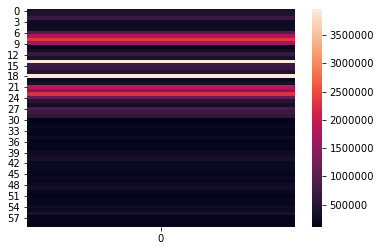

In [20]:
print(gradients_before_burnin[:D].sum())
print(gradients_before_burnin[D:].sum())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(11026756., device='cuda:0')
tensor(659332.3750, device='cuda:0')


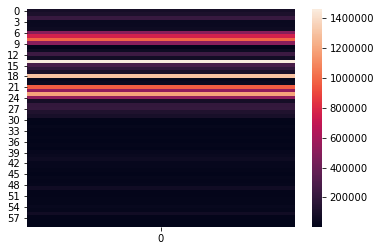

In [21]:
print(gradient_post_burn_in[:D].sum())
print(gradient_post_burn_in[D:].sum())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(8415.6982, device='cuda:0')
tensor(3104.3013, device='cuda:0')


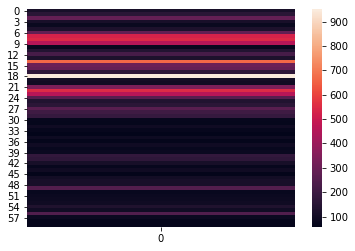

In [22]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(2578.4629, device='cuda:0')
tensor(301.5371, device='cuda:0')


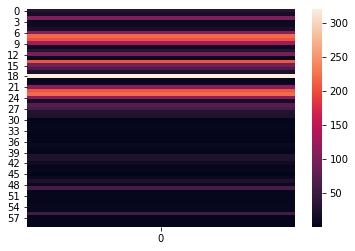

In [23]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[(D):].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [24]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(2276.9258, device='cuda:0')

In [25]:
sub = vae_gumbel_truncated.subset_indices

In [26]:
top_ind = torch.argmax(vae_gumbel_truncated.subset_indices, dim = 1)
top_ind

tensor([ 7, 14, 24,  6, 49,  9, 18, 22,  9, 23, 14, 21, 12, 23, 22, 18, 50,  2,
        24, 18, 15, 41,  8,  7], device='cuda:0')

In [27]:
sum(top_ind < 30)

tensor(21, device='cuda:0')

In [28]:
sum(top_ind >= 30)

tensor(3, device='cuda:0')

LIst logits and subsets. Compare them to each and the ones from other methods (if we had any)

In [29]:
with torch.no_grad():
    z = vae_gumbel_truncated.logit_enc.sum(dim = 0)
z

tensor([  1.5067, -13.5860,   1.8955,   0.3409, -16.7963,  -8.9521,  -7.4211,
         14.6163,  14.1930,  15.1094, -16.4678,  -8.7232,   4.5836, -16.9789,
          8.0156,  -4.1779,   7.0767,  -3.1953,  10.0835,  -4.6147,  -1.6574,
          3.7767,   5.8198,  12.8215, -19.1532,  -1.5217,  -8.3763,   7.3167,
          9.0459,   2.2569, -10.5327, -13.8465,  -9.6300,  -6.0035, -12.2440,
         -6.1765, -11.5554, -11.5829, -11.2524, -11.6598, -12.9819,   0.0727,
         -8.8582, -15.3666,  -5.7361,  -9.3291,  -8.7789, -14.8133,  -9.2695,
         -7.4011,  -7.8189,  -8.3566, -10.4280,  -7.7997,  -5.3804,  -1.5703,
         -2.6198,  -5.7974, -15.2785, -10.3733], device='cuda:0')

In [30]:
torch.sum(vae_gumbel_truncated.subset_indices, dim = 0)

tensor([3.0663e-30, 1.2209e-08, 1.0000e+00, 0.0000e+00, 4.9444e-37, 3.1117e-25,
        1.0000e+00, 2.0072e+00, 1.0000e+00, 2.2557e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 5.1871e-10, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 7.3711e-01, 2.0001e+00, 2.0000e+00,
        1.9999e+00, 0.0000e+00, 2.0759e-11, 5.7773e-16, 0.0000e+00, 2.0974e-23,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0277e-31, 1.0000e+00,
        0.0000e+00, 1.7569e-24, 0.0000e+00, 0.0000e+00, 4.2942e-39, 0.0000e+00,
        8.4078e-45, 1.0000e+00, 1.0000e+00, 1.5975e-43, 4.3201e-27, 0.0000e+00,
        4.4351e-32, 0.0000e+00, 6.0256e-44, 0.0000e+00, 0.0000e+00, 2.9609e-42],
       device='cuda:0')

Cannot as easily compare as them as you could for the other methods